# The Classification of Wine
##### Group 27: Richard Li, Herman Liao, Chi Pham, Georgia Simkin

## Introduction 

Given the chemical properties (specifically, Flavanoid and Color Intensity) of an unknown wine, is it possible to accurately classify the wine's type?

We are using the Wine Dataset from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/wine). In which different types of wine (Pinot Noir, Merlot, and Cabernet Sauvignon), grown in the same region but using different cultivators, are examined.  The different cultivators allow for different chemical constituents of each type of wine, hence, the goal of this project is to see if we can classify types of wine given chemical predictors.

According to Jonathon Betchels (https://jonathonbechtel.com/blog/2018/02/06/wines/), it’s most likely the three classes of wine in the set: 1, 2, and 3 matches with Pinot Noir, Cabernet Sauvignon, and Merlot respectively. This set also contains data on 13 attributes: Alcohol content, Malic Acid, Ash, Magnesium, Total Phenols, Flavanoids, Nonflavanoid Phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline. There are 178 different observations of wine samples in this data set.

## Preliminary exploratory data analysis

First, we load all necessary packages and libraries.

In [36]:
# Install and load necessary packages
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)
install.packages("GGally")
library(GGally)

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We set the seed value to make this report reproducible, and set the display options.

In [37]:
# Set seed and options
set.seed(27)
options(repr.matrix.max.rows = 15)

#### Read data set into R
We begin by loading the data set directly from the web into R. The original data set did not contain column names so we set `col_names` to `FALSE`.

In [38]:
# Read dataset from the web into R
wine <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", 
                 col_names = FALSE)
head(wine)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_double(),
  X13 = col_double(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


#### Clean and Wrangle
We first assign the column names given by the data set's description.

The first column is our class, and it's currently of type numeric (`<dbl>`). Since we'll be treating class as a categorical variable, we'll convert it to type factor. We noticed that `mg` (X6) and `proline` (X14) have integer values, so we will also convert them to type `<int>`.

In [39]:
# Assign column names
colnames(wine) <- c("class", "alcohol", "acid", "ash", "alcalinity", "mg", "total_phenol", 
                    "flavanoid", "non_f_phenol", "proantho", "color", "hue", "od280/od315", "proline")

# Convert type where applicable
wine <- wine %>%
        mutate(class = as.factor(class), mg = as.integer(mg), proline = as.integer(proline))
head(wine)

class,alcohol,acid,ash,alcalinity,mg,total_phenol,flavanoid,non_f_phenol,proantho,color,hue,od280/od315,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


Before splitting the data set, we will check whether there is any missing value.

In [40]:
# Number of missing values in the data set
sum(is.na(wine))

[1] 0

We will split the data so that 75% of our original data is in the training set and 25% in the testing set. 

In [41]:
# Split wine data into training and testing data
wine_split <- initial_split(wine, prop = 0.75, strata = class)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

head(wine)

class,alcohol,acid,ash,alcalinity,mg,total_phenol,flavanoid,non_f_phenol,proantho,color,hue,od280/od315,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


We noticed that some variables do not influence the classification of wine as much as others. So we want to narrow down the number of possible predictors before going into further exploratory and choosing our 2 main predictors. Using a matrix plot, we will visualize the distribution of classes within all variables to decide which variables we should eliminate.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



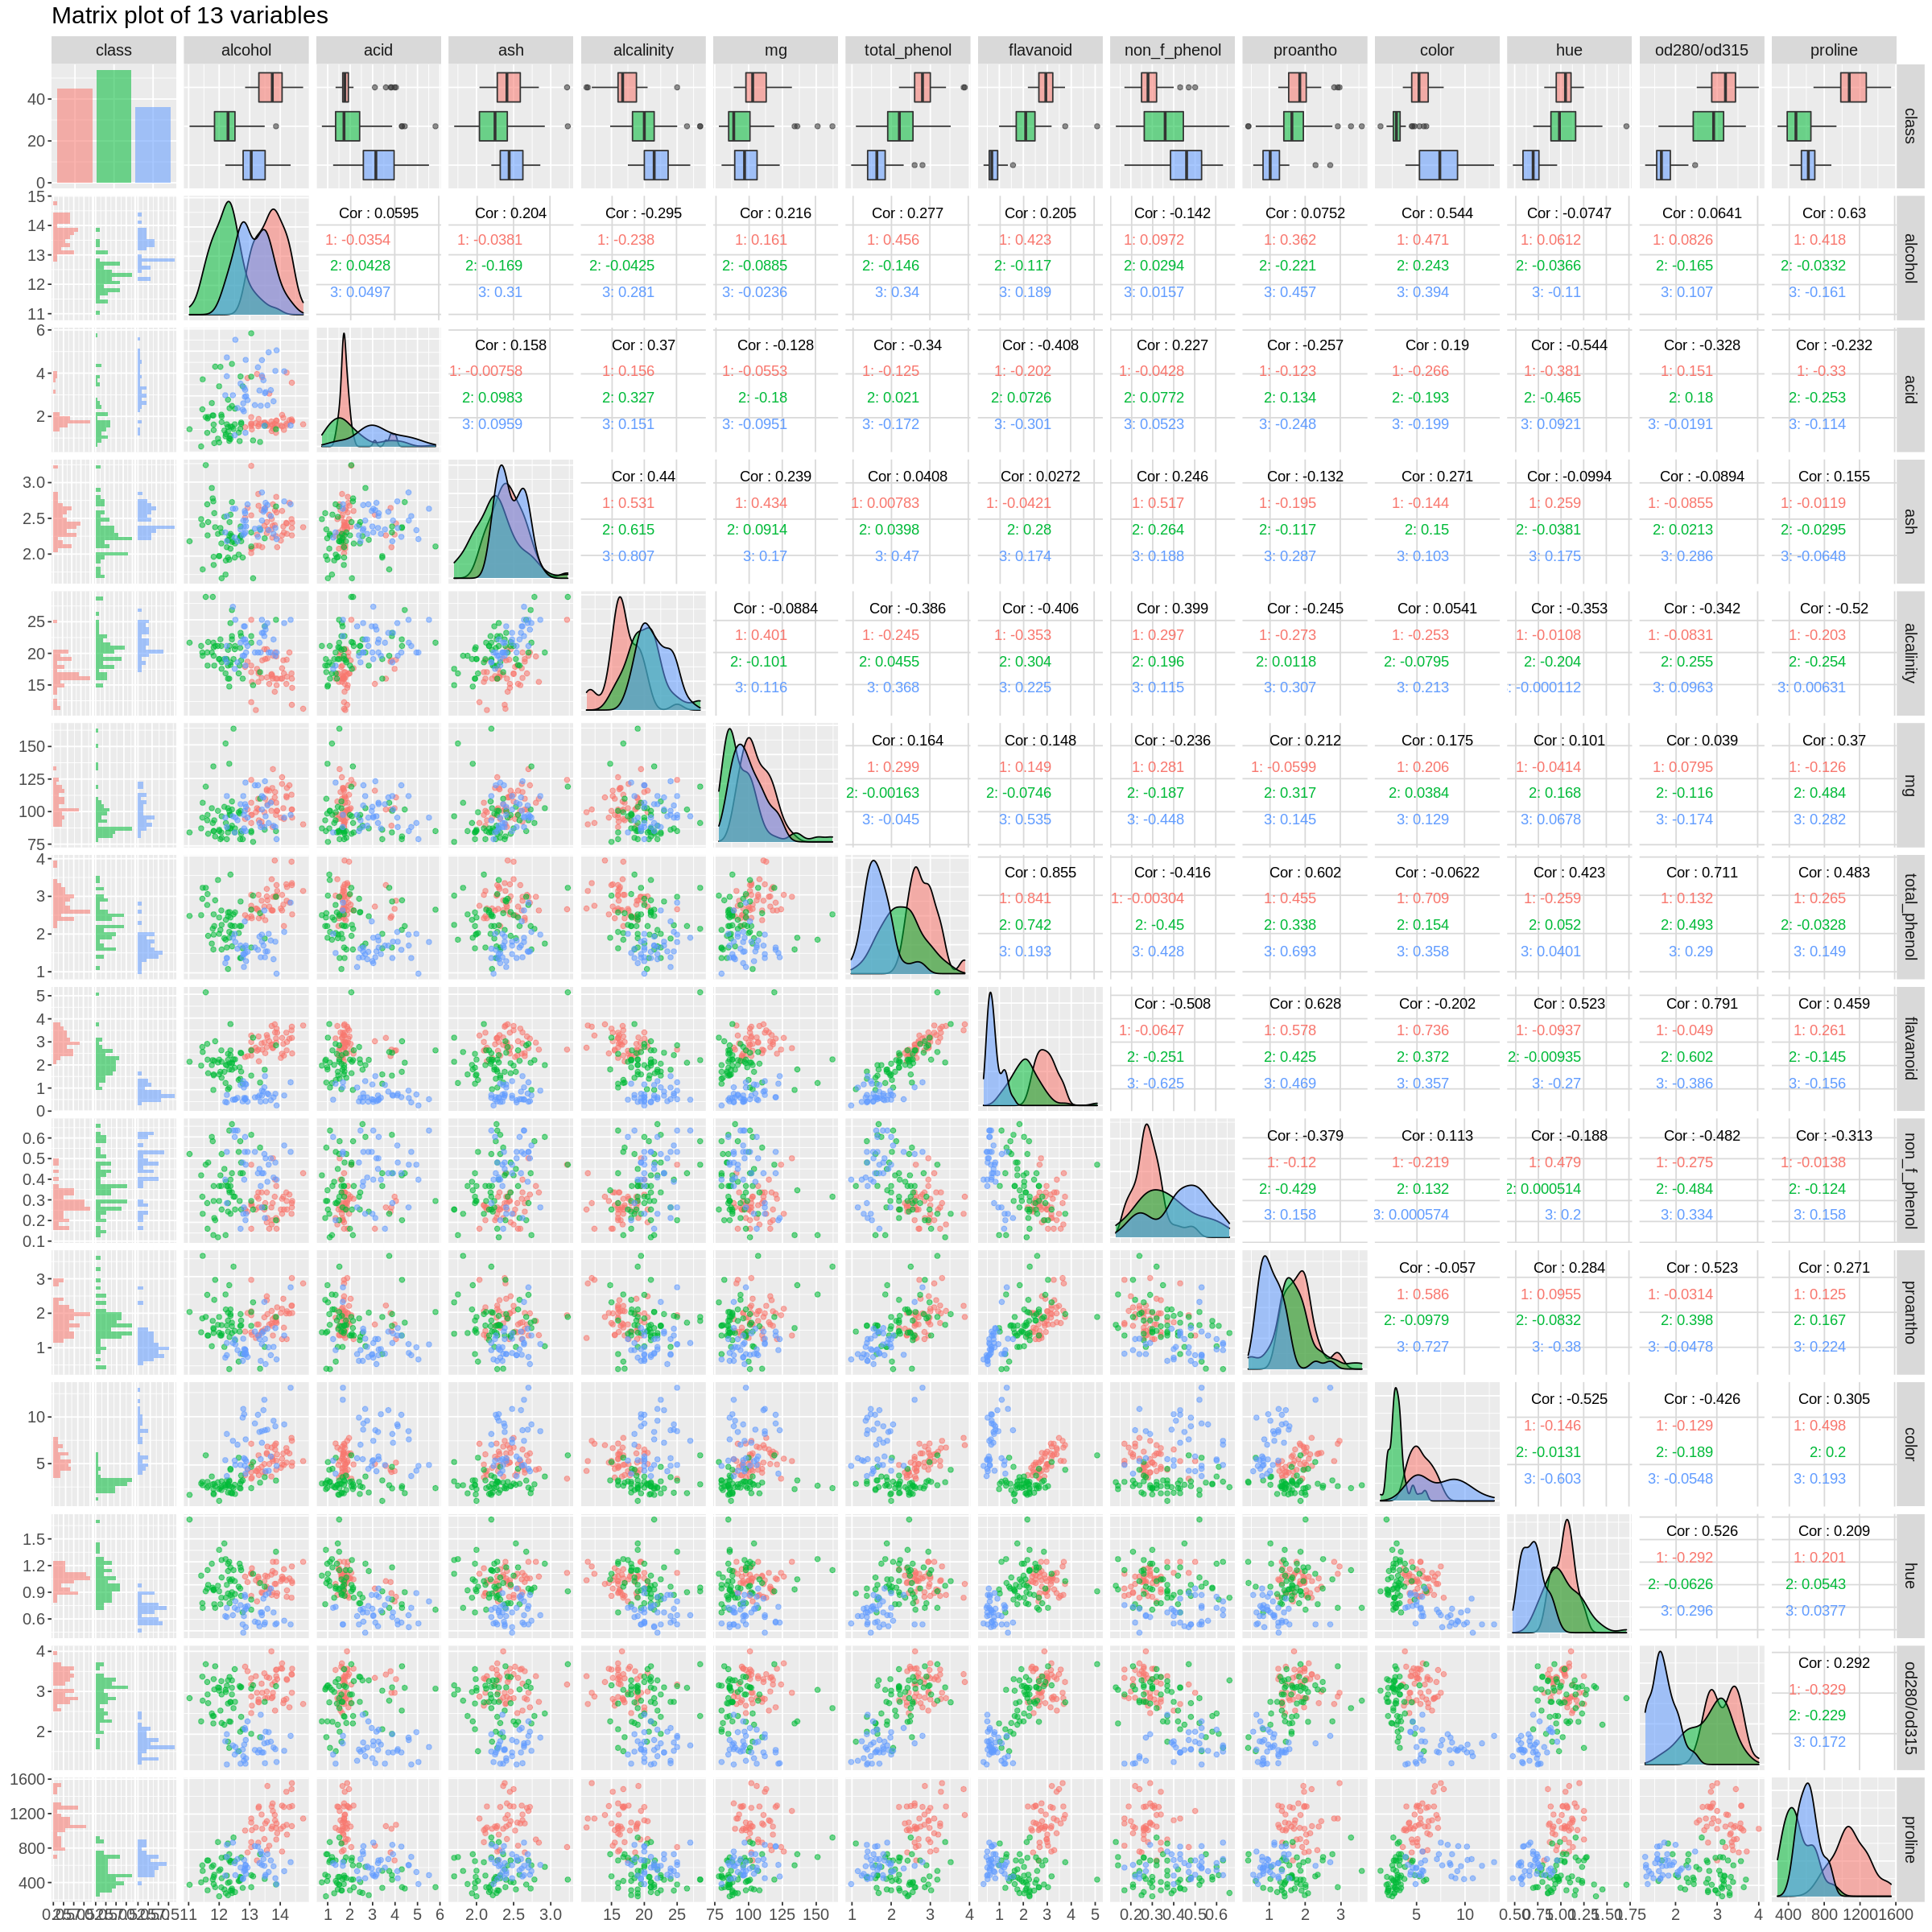

In [62]:
# Matrix plot of 13 variables
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(wine_training, aes(color = class, alpha = 0.5), title = "Matrix plot of 13 variables") +
    theme(text = element_text(size = 15))

Looking at the boxplots and histograms of 13 variables above, we could see that the distribution of different wine classes within `alcohol`, `flavanoid`, `color`, `hue`, `proline` are more distinct compared to the other variables (the classes of wine overleaps the least). The distiction between each classes of wine within the variables indicates a higher influence on the classification of wine types. Hence, we decided to narrow down to exploring these 5 variables as we believed they were more relevant to `class`.

We will create a new data set with the chosen variables: `alcohol`, `flavanoid`, `color`, `hue`, `proline` , calling it `wine_main`.

In [65]:
# Create new data set with chosen variables
wine_main <- select(wine_training, class, alcohol, flavanoid, color, hue, proline)

#### Summarization

First, we will report the number of total observations, number of variables, and missing values of the training data set. We will also check the number of observations in each class to see if they are balanced.

In [66]:
# Set display options for values
options(digits = 4)

# Create summary table of total observations, variables, and missing values of data set
total_observations <- nrow(wine_training)
total_variables <- ncol(wine_training)
total_na <- sum(is.na(wine_training))
table1 <- data.frame(total_observations, total_variables, total_na)

# Create summary table of observations in each class of data set
obs_per_class <- wine_training %>%
    group_by(class) %>%
    summarize(count = n(),
    percentage = n() / total_observations * 100)

`summarise()` ungrouping output (override with `.groups` argument)


In [67]:
# Number of total observations, variables (including class), and missing values
table1

total_observations,total_variables,total_na
<int>,<int>,<int>
135,14,0


In [45]:
# Number and percentage of observations in each class
obs_per_class

class,count,percentage
<fct>,<int>,<dbl>
1,45,33.33
2,54,40.00
3,36,26.67


From the table above, we can see that the numbers of observations are quite balanced.

Since we will only explore further 5 main variables, we will only summarise the means and standard deviation of variables within the `wine_main` set.

In [ ]:
# Creat summary table for the means and standard deviation of chosen variables
means_of_var <- wine_main %>%
    summarize(across(alcohol:proline, mean)) %>%
    pivot_longer(cols = alcohol:proline,
                 names_to = "chemical_components",
                 values_to = "mean")

sd_of_var <- wine_main %>%
    select(alcohol:proline) %>%
    map_dfr(sd) %>%
    pivot_longer(cols = alcohol:proline,
                 names_to = "chemical_components",
                 values_to = "sd") %>%
    select(sd)

summary_tbl <- bind_cols(means_of_var, sd_of_var) %>%
    arrange(mean)

In [46]:
# Means and SD of chosen variables, arranged in ascending order by mean
summary_tbl

chemical_components,mean,sd
<chr>,<dbl>,<dbl>
hue,0.944,0.2139
flavanoid,2.046,0.9869
color,5.009,2.3287
alcohol,12.975,0.8128
proline,742.556,306.3759


Looking at the table above, if one of our two main predictors were `proline` or `alcohol`, we would certainly need to scale our variables since the K-nearest neighbours algorithm we are using performs classification based on straight-line distance. If our predictors were `hue` and `flavanoid` or `flavanoid` and `color`, scaling might not be necessary since the range of these variables are quite close. Regardless, we would still perform scaling as it is good practice.

#### Choosing two main predictors & Visualization

For our main data analysis, we wanted to use only two predictors. Here, we will examine each pair of variables in the chosen set above, and narrow down to two. We do this by a examining a matrix plot of the main variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



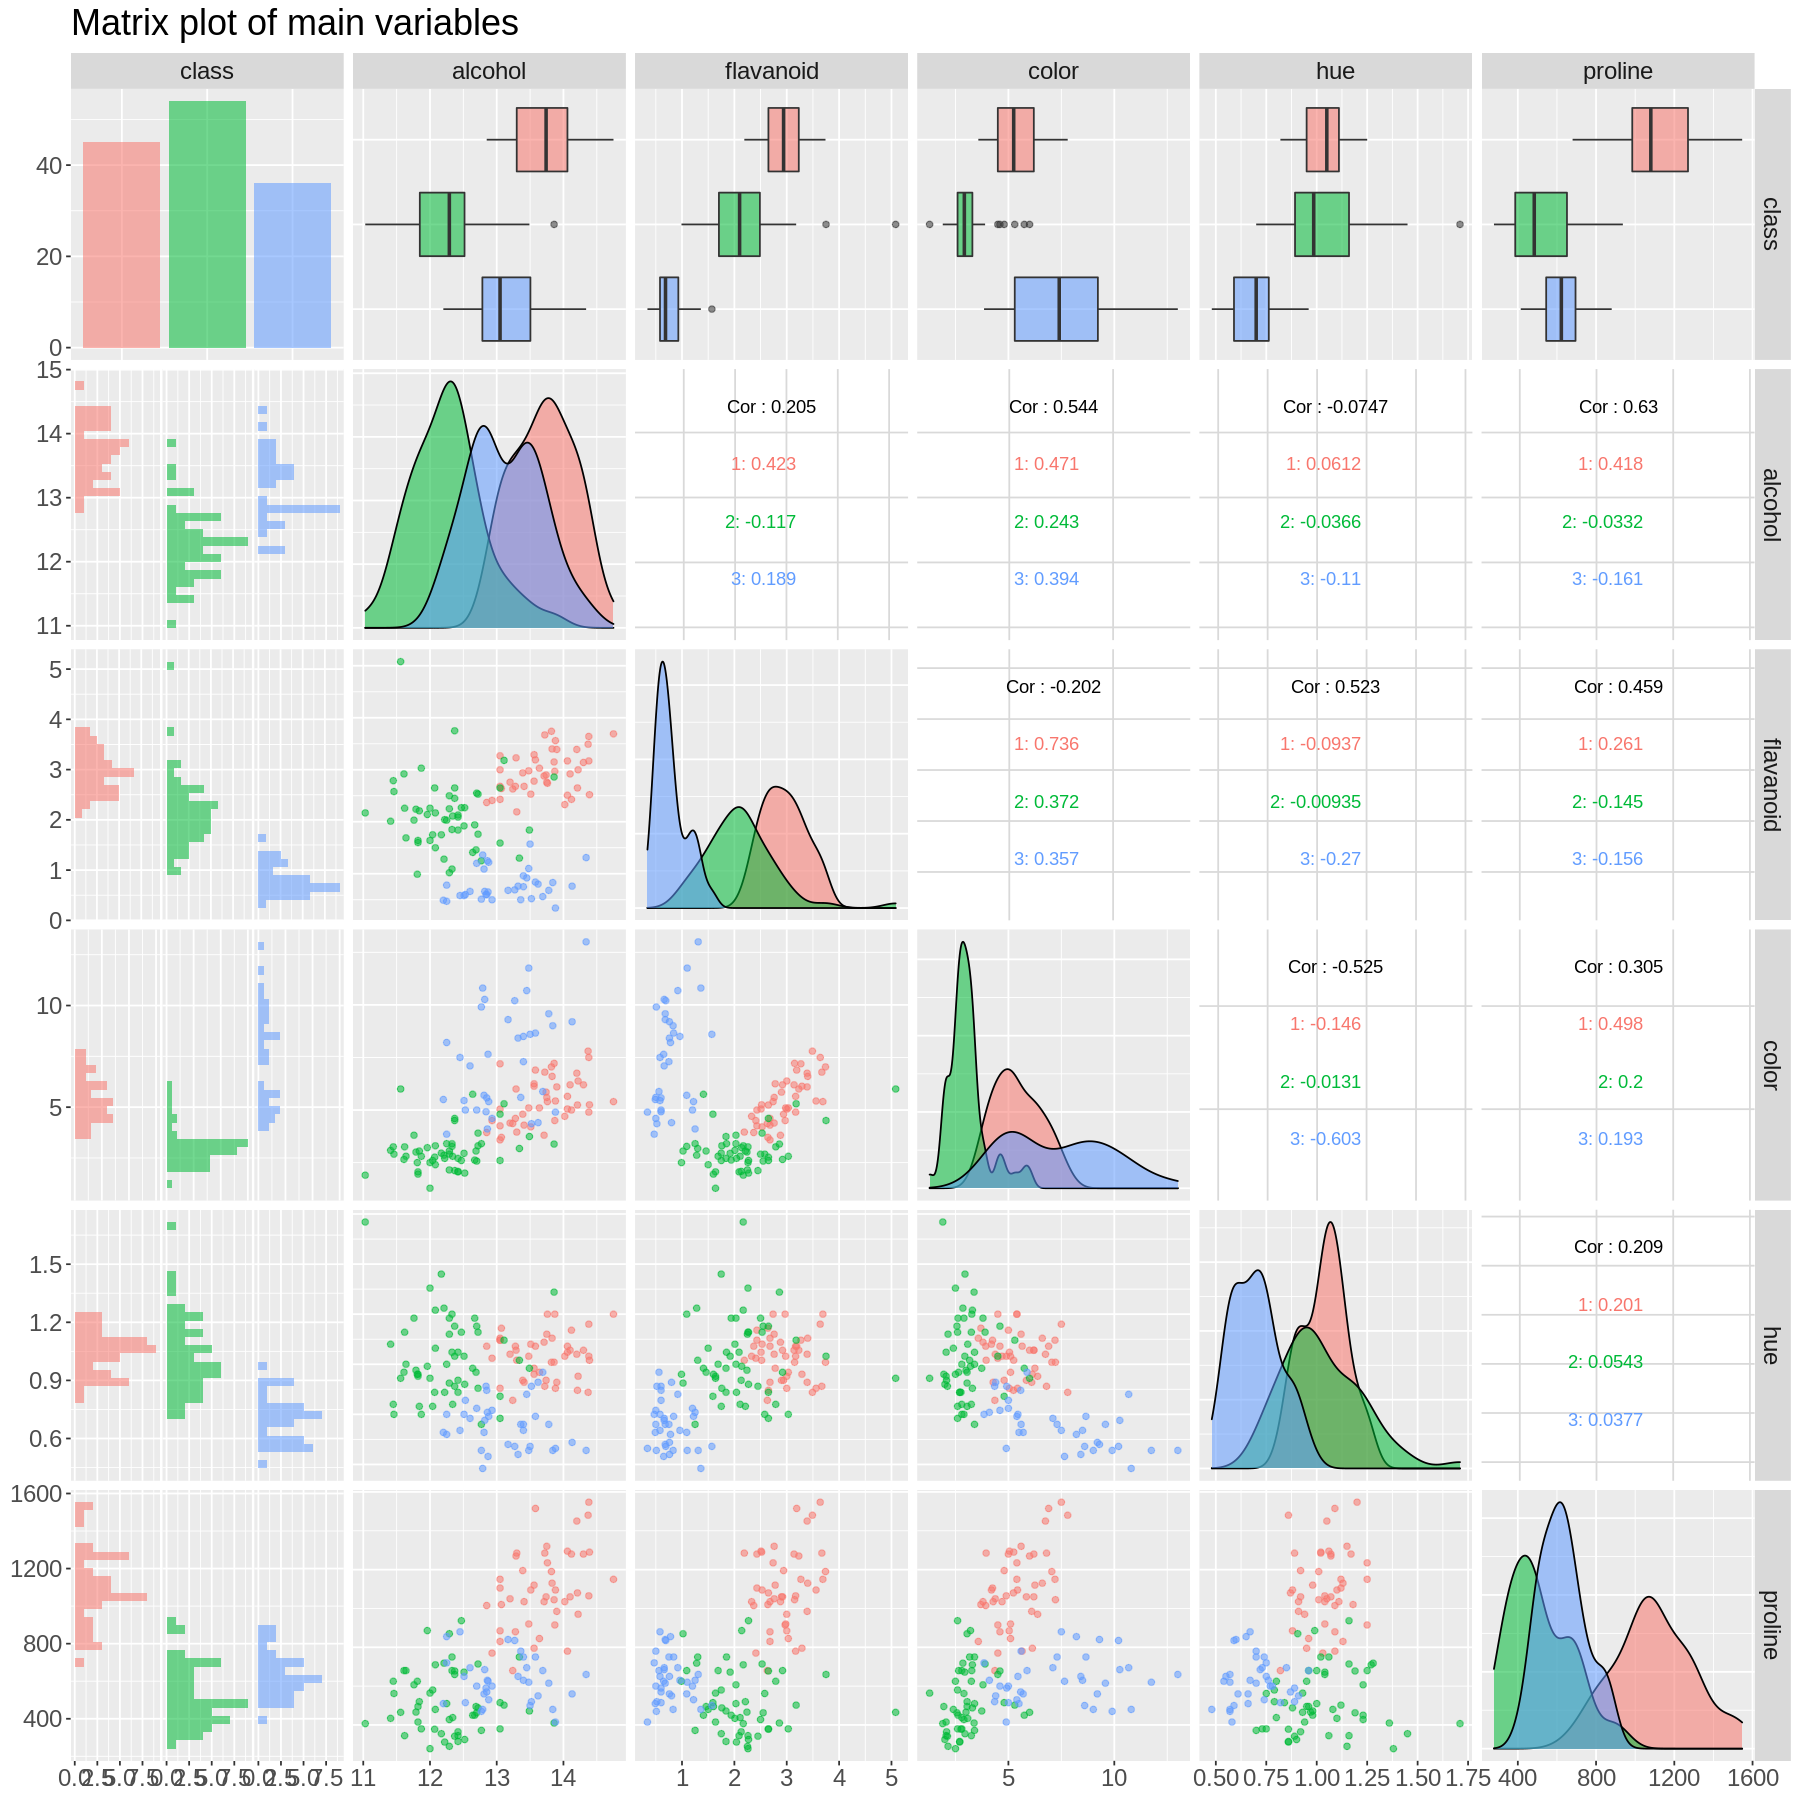

In [70]:
# Visualization using matrix plot to examine each pair of variables in the chosen set
options(repr.plot.width = 15, repr.plot.height = 15)
ggpairs(wine_main, aes(color = class, alpha = 0.5), title = "Matrix plot of main variables") +
    theme(text = element_text(size = 18))

Looking at the matrix plot above (histograms and box plots), it’s apparent the distribution of different wine classes within `flavanoid` and `color` overlaps the least in comparison to other variables. The separation of different classes within a variable makes the classification of wine type clearer as each type would have a more distinct range of values within the variable. Furthermore, in examining the scatter plot of `flavanoid` and `color` it’s evident there is little overplotting of classes' data points, as well as the distribution of different classes are distinct. Hence, we believe `flavanoid` and `color` would be the best predictors for this project.

We will generate a visualization of classes within our two main predictors below.

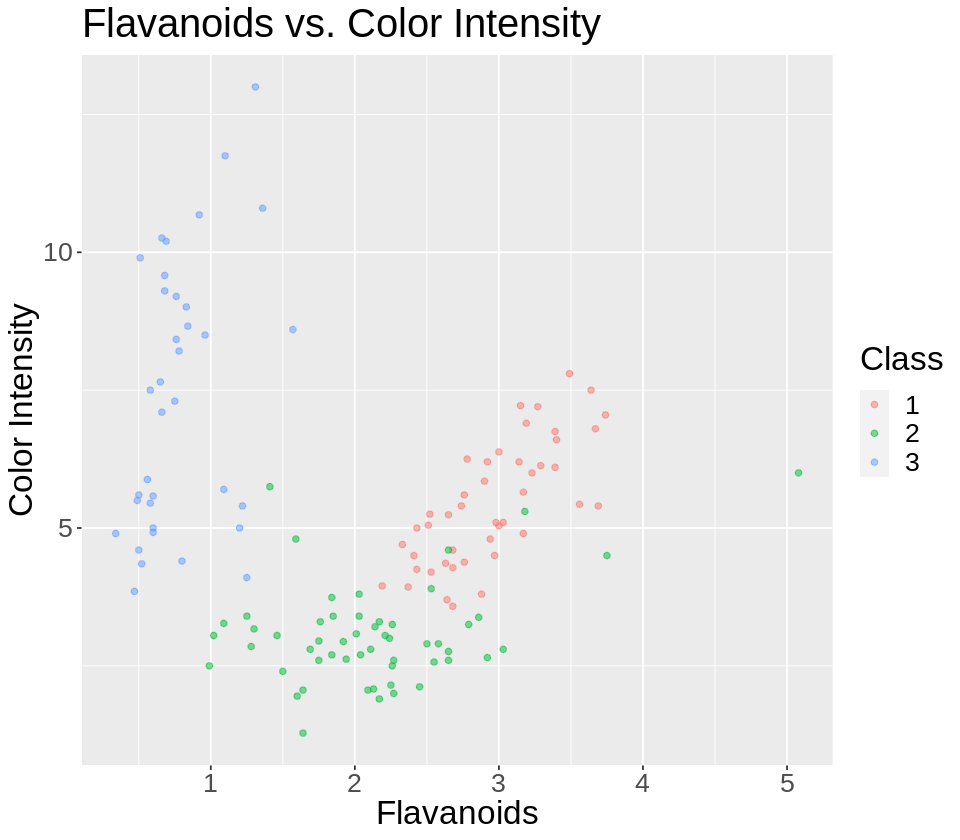

In [72]:
# Clearer scatter plot of Flavanoid vs Color Intensity 
options(repr.plot.width = 8, repr.plot.height = 7)
plot_flava_color <- ggplot(wine_training, aes(x = flavanoid, y = color, color = class)) +
                      geom_point(alpha = 0.5) +
                      labs(x = "Flavanoids", y = "Color Intensity", color = "Class") +
                      ggtitle("Flavanoids vs. Color Intensity") +
                      theme(text = element_text(size = 20))
plot_flava_color

## Data Analysis
Step 1: Find best number of nearest neighbors.

Step 1.1: Create a tuning model and recipe.

In [49]:
wine_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                  set_engine("kknn") %>%
                  set_mode("classification")
wine_recipe <- recipe(class ~ flavanoid + color, data = wine_training) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())
wine_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Step 1.2: Create a tuning cross-validation and workflow.

In [50]:
# Change number of folds to increase or decrease accuracy!  Best seems to be 5 folds.
wine_vfold <- vfold_cv(wine_training, v = 5, strata = class)
wine_tune_workflow <- workflow() %>%
                      add_recipe(wine_recipe) %>%
                      add_model(wine_tune_spec)
wine_tune_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Step 1.3: Use the workflow and cross-validation to find the best number of nearest neighbours.

In [51]:
# From 1 to 10: Best neighbours is 3
# From 1 to 20: Best neighbours is 3
# From 1 to 25: Best neighbours is 25
# From 1 to 30: Best neighbours is 30
# From 1 to 40: Best neighbours is 40
# From 1 to 50: Best neighbours is 47
# So far, 3 neighbours consistently gives high accuracies
gridvals <- tibble(neighbors = seq(from = 1, to = 20))
wine_tune_results <- wine_tune_workflow %>%
                     tune_grid(resamples = wine_vfold, grid = gridvals) %>%
                     collect_metrics()
wine_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9113,5,0.018360,Model01
1,roc_auc,hand_till,0.9384,5,0.012154,Model01
2,accuracy,multiclass,0.9113,5,0.018360,Model02
2,roc_auc,hand_till,0.9617,5,0.011095,Model02
3,accuracy,multiclass,0.9111,5,0.022276,Model03
3,roc_auc,hand_till,0.9638,5,0.010900,Model03
4,accuracy,multiclass,0.9111,5,0.022276,Model04
4,roc_auc,hand_till,0.9777,5,0.008154,Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [52]:
# I have no idea what roc_auc is, but it's suggesting 1 neighbour, so I think we should choose accuracy instead.
wine_min_neighbours_table <- wine_tune_results %>%
                             filter(.metric == "accuracy") %>%
                             arrange(mean) %>%
                             slice(1)
wine_min_neighbours_table

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.9111,5,0.02228,Model03


In [53]:
wine_min_neighbours <- pull(wine_min_neighbours_table, neighbors)
wine_min_neighbours

[1] 3

Step 2: Use the best number of neighbours to rebuild a best model and recipe for predictions.

Step 2.1: Create a best model.

In [54]:
wine_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_min_neighbours) %>%
                  set_engine("kknn") %>%
                  set_mode("classification")

Step 2.2: Create a best workflow.

In [55]:
wine_best_workflow <- workflow() %>%
                      add_recipe(wine_recipe) %>%
                      add_model(wine_best_spec)

Step 2.3: Fit the workflow to the training data.

In [56]:
wine_fit <- fit(wine_best_workflow, data = wine_training)

Step 2.4: Make predictions by using the fitted workflow on the testing data.

In [57]:
wine_predictions <- wine_fit %>%
                    predict(wine_testing) %>%
                    bind_cols(wine_testing)
head(wine_predictions)

.pred_class,class,alcohol,acid,ash,alcalinity,mg,total_phenol,flavanoid,non_f_phenol,proantho,color,hue,od280/od315,proline
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
1,1,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510
1,1,13.63,1.81,2.70,17.2,112,2.85,2.91,0.30,1.46,7.30,1.28,2.88,1310


Step 2.5: Measure accuracy of the predictions.

In [58]:
wine_accuracy <- wine_predictions %>%
                 metrics(truth = class, estimate = .pred_class)
wine_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9070
kap,multiclass,0.8604


Step 2.6: Visualize test data class actuals and predictions using scatter plots.

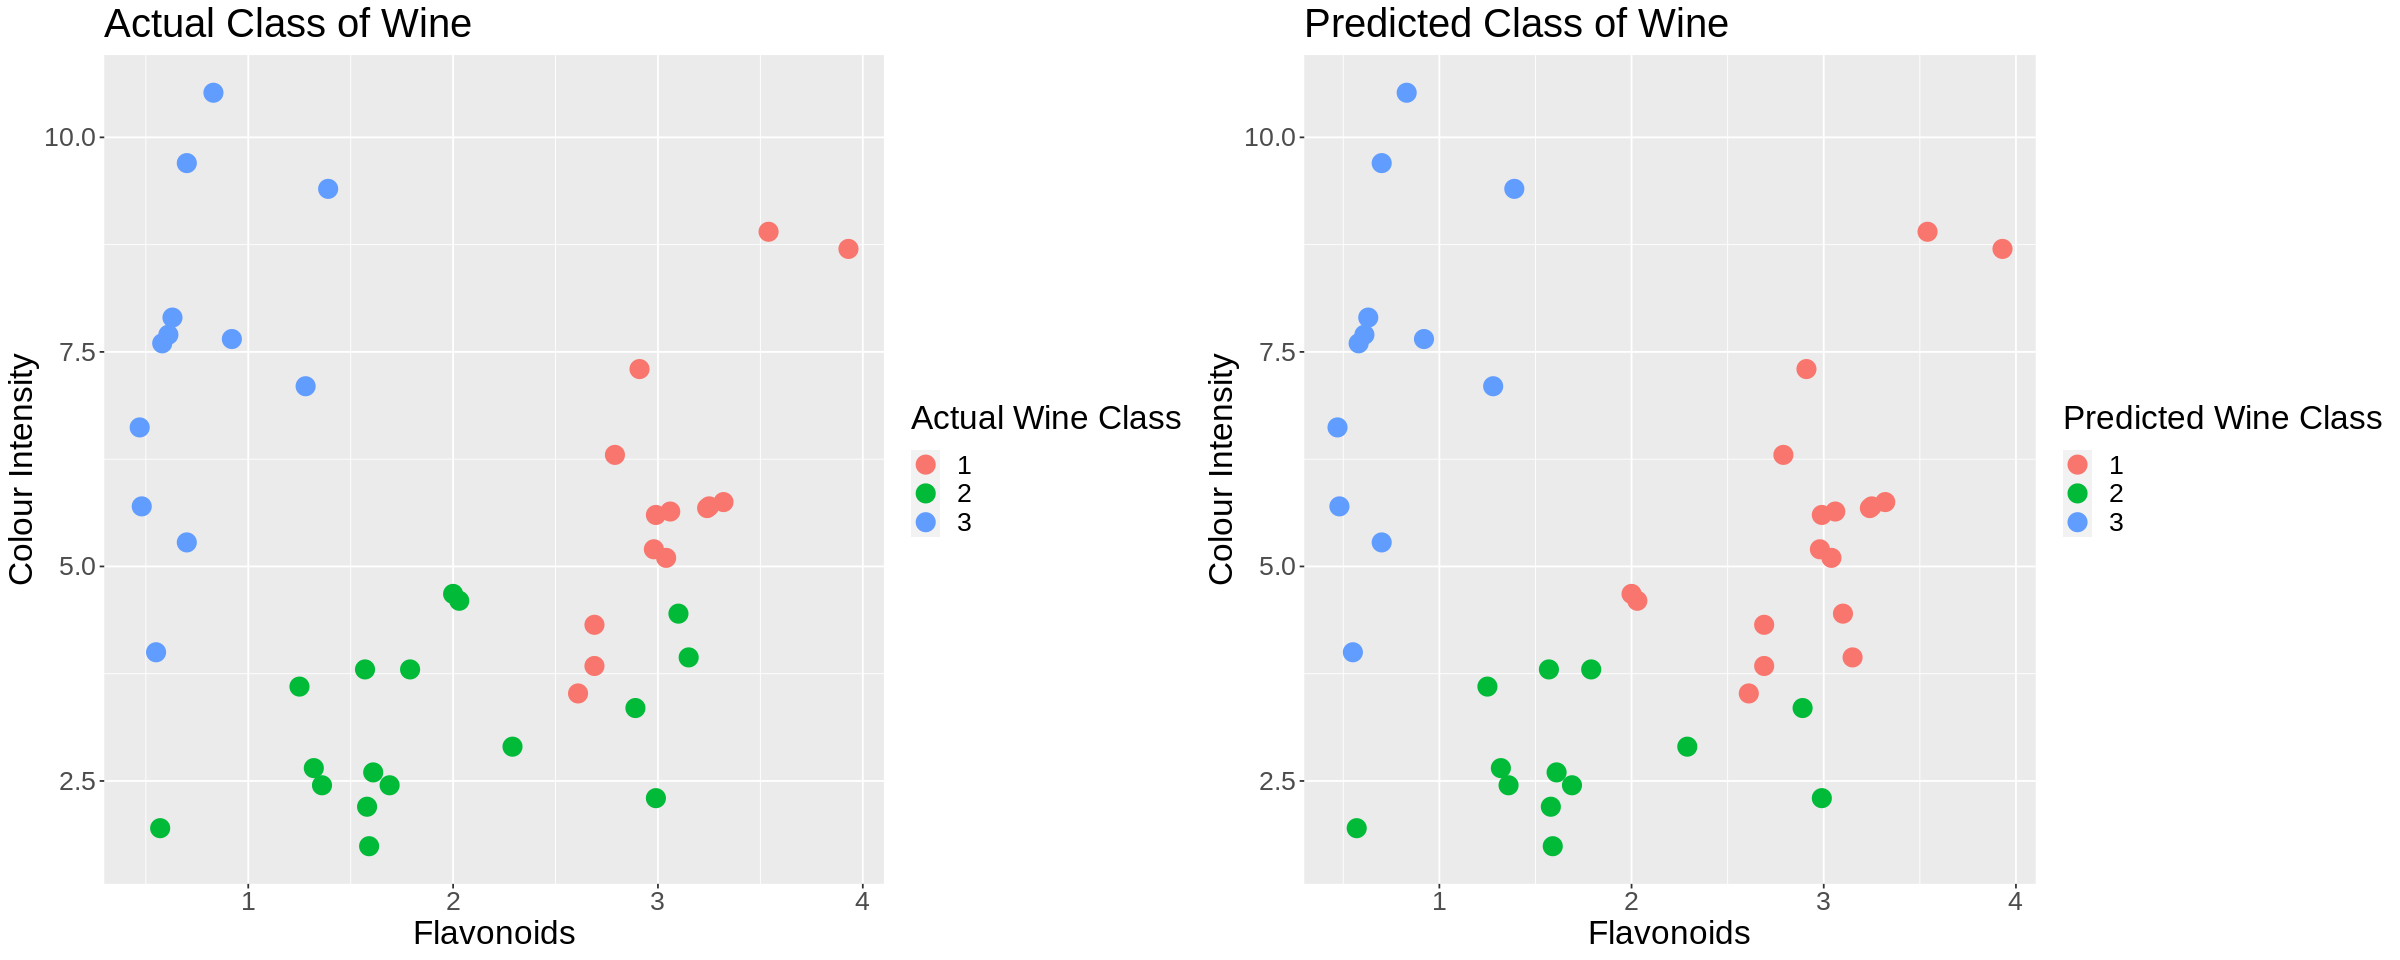

In [59]:
options(repr.plot.width = 20, repr.plot.height = 8)

actual_plot <- ggplot(wine_predictions, aes(x = flavanoid, y = color)) +
    geom_point(aes(color = class), size = 5) +
    labs(x = "Flavonoids", y = "Colour Intensity", color = "Actual Wine Class") +
    ggtitle("Actual Class of Wine") +
    theme(text = element_text(size = 20))

predict_plot <- ggplot(wine_predictions, aes(x = flavanoid, y = color)) +
    geom_point(aes(color = .pred_class), size = 5) +
    labs(x = "Flavonoids", y = "Colour Intensity", color = "Predicted Wine Class") +
    ggtitle("Predicted Class of Wine") +
    theme(text = element_text(size = 20))

plot_grid(actual_plot, predict_plot, nrow = 1)

Confusion matrix

In [60]:
confusion <- wine_predictions %>%
    conf_mat(truth = class, estimate = .pred_class)
confusion

          Truth
Prediction  1  2  3
         1 14  4  0
         2  0 13  0
         3  0  0 12

Overfitting/Underfitting Plots

In [61]:
flav_grid <- seq(min(wine_main$flavanoid, na.rm = TRUE),
                 max(wine_main$flavanoid, na.rm = TRUE),
                 length.out = 100)
color_grid <- seq(min(wine_main$color, na.rm = TRUE),
                  max(wine_main$color, na.rm = TRUE),
                  length.out = 100)

complete_grid <- as_tibble(expand.grid(flavanoid = flav_grid,
                                       color = color_grid))

### Methods
With the reasoning given above and further research, we decided to use Flavanoids and Color Intensity as predictors. `class`, `flavanoid`, `color` will be columns used in data analysis 

This is a classification problem so we use the K-nearest neighbors algorithm. The main library used to perform this algorithm is `tidymodels`.

Scatter plots, Line plots, Tables will be used for visualization. Scatter plot could be for visualizing the distribution of class given predictors. Line plots are used when determining K. Tables are used to display results like classifier's accuracy.

### Expected outcomes and significance
We expect to find the most relevant class for an unknown wine type given its chemical analysis. We hope that our model's accuracy could fall above 85%.

The impact of these findings are significant, as within British Columbia the wine industry contributes an annual 2.8 billion dollars, and 339.53 billion globally. Consumers are specific on the type of wine they wish to purchase so accurately classifying the types of wine are important to the wine industry. 

This classification could lead to a vast possibility of questions such as: Is one type of wine healthier to consume than another? Which type of wine is more sought after and more heavily consumed?


